In [ ]:
import nltk 
import numpy as np
import pandas as pd
import string

from sklearn.utils import shuffle

import re
#from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer

import csv 
import ast

In [ ]:
!pip install transformers==3.2.0
!pip install tensorflow_addons

from transformers import *
from transformers import BertTokenizer, TFBertModel, BertConfig
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools, pickle
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.0MB 5.5MB/s 
     |████████████████████████████████| 3.0MB 21.8MB/s 
     |████████████████████████████████| 1.2MB 50.4MB/s 
     |████████████████████████████████| 870kB 54.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4a4f93765c70e23c0a2f7dc2a7e85a5315f35ba11326494acc38783eda9b7096
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses
     |████████████████████████████████| 706kB 4.4MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/My Drive/labelled_data.csv',
                 lineterminator='\n')
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Unnamed: 0,Processed,Raw,Date,Location\r,scores,compound,sentiment_type,sen_label
0,564,costco administ covid vaccine,Costco Is Now Administering COVID-19 Vaccines ...,2021-02-19 23:35:37+00:00,Lindholm Metal Smart+ Lofts\r,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,NEUTRAL,1
1,7393,ireland countri probabl highest concentr pharm...,Ireland - A Country that probably has the high...,2021-02-19 19:50:03+00:00,\r,"{'neg': 0.091, 'neu': 0.909, 'pos': 0.0, 'comp...",-0.250,NEGATIVE,2
2,58232,nyc waitress fire refus covid vaccine,NYC Waitress Fired For Refusing COVID Vaccine ...,2021-02-18 23:41:07+00:00,\r,"{'neg': 0.324, 'neu': 0.676, 'pos': 0.0, 'comp...",-0.340,NEGATIVE,2
3,36238,world sick vaccine heal ail world amp inhabit ...,"@reuterspictures @Lucy_nic Our world is ""sick....",2021-02-09 18:47:21+00:00,Olam Ha-Ba\r,"{'neg': 0.207, 'neu': 0.565, 'pos': 0.228, 'co...",-0.296,NEGATIVE,2
4,1838,report tweet user spread misinform covid vaccine,@Policy @TwitterSafety how can I report a twe...,2021-02-19 22:45:44+00:00,"Asuncion, Paraguay\r","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,NEUTRAL,1


In [ ]:
all_data = data[['Processed', 'sen_label']].copy()
all_data

,Processed,sen_label
0,costco administ covid vaccine,1
1,ireland countri probabl highest concentr pharm...,2
2,nyc waitress fire refus covid vaccine,2
3,world sick vaccine heal ail world amp inhabit ...,2
4,report tweet user spread misinform covid vaccine,1
...,...,...
40762,special thank belov pm corona vaccine,0
40763,short vaccine state find hidden stash backyard...,1
40764,u storm delay covid vaccine state white house,2
40765,shot give protect research lend support decis ...,0


In [ ]:
all_data['Processed'] = all_data['Processed'].astype('string')
y_data = all_data['sen_label']

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
input_ids=[]
attention_masks=[]

for sentence in all_data['Processed']:
    bert_inp=bert_tokenizer.encode_plus(sentence,add_special_tokens = True, truncation=True, max_length =34 ,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(y_data)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# test and train split for training. 
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.1)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))

Train inp shape (36690, 34) Val input shape (4077, 34)
Train label shape (36690,) Val label shape (4077,)
Train attention mask shape (36690, 34) Val attention mask shape (4077, 34)


In [ ]:
# callback for early stopping.
log_dir='tensorboard_data/tb_bert'
model_save_path='/content/drive/My Drive/models/bert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

print('\nBert Model',bert_model.summary())




Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2307      
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________

Bert Model None


In [ ]:
# Loss function and optimiser. 
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tfa.optimizers.LAMB(learning_rate=2e-5,epsilon=1e-08)

bert_model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

In [ ]:
# model training. 
history=bert_model.fit([train_inp,train_mask],
                       train_label,batch_size=32,
                       epochs=5,
                       validation_data=([val_inp,val_mask],val_label),
                       callbacks = callbacks
                       )

Epoch 1/5
1147/1147 [==============================] - 268s 204ms/step - loss: 0.8786 - accuracy: 0.5921 - val_loss: 0.3670 - val_accuracy: 0.8720
Epoch 2/5
1147/1147 [==============================] - 228s 199ms/step - loss: 0.3121 - accuracy: 0.8922 - val_loss: 0.2366 - val_accuracy: 0.9242
Epoch 3/5
1147/1147 [==============================] - 228s 199ms/step - loss: 0.1798 - accuracy: 0.9402 - val_loss: 0.1822 - val_accuracy: 0.9433
Epoch 4/5
1147/1147 [==============================] - 228s 199ms/step - loss: 0.1302 - accuracy: 0.9585 - val_loss: 0.1647 - val_accuracy: 0.9502
Epoch 5/5
1147/1147 [==============================] - 228s 199ms/step - loss: 0.0951 - accuracy: 0.9704 - val_loss: 0.1491 - val_accuracy: 0.9532


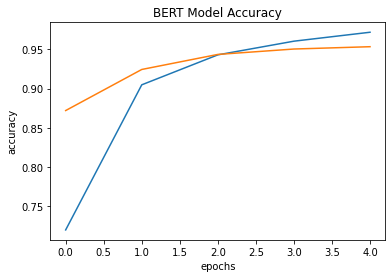

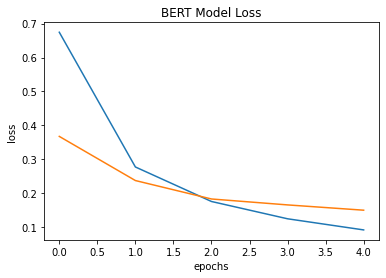

In [ ]:
# The plots for loss and accuracy of the model.
plt.figure(1)
plt.title('BERT Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.savefig('/content/drive/My Drive/figures/BERT_accuracy.png')

plt.figure(2)
plt.title('BERT Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('/content/drive/My Drive/figures/BERT_loss.png')

In [ ]:
# predicted values for performance metrics. 
import time

t1 = time.time()
y_pred = bert_model.predict(val_inp)

for n in y_pred:
      predict = np.argmax(n, axis=1)
t2 = time.time()
print( 'Time taken for predictions {} seconds'.format( t2 - t1))



print(predict)
print(val_label)

Time taken for predictions 9.383216142654419 seconds
[0 2 2 ... 0 2 0]
[0 2 2 ... 0 2 0]


In [ ]:
# classification report. 
classes = ["positive", "neutral", "negative"]

print(classification_report(val_label, predict, target_names=classes))

              precision    recall  f1-score   support

    positive       0.96      0.93      0.94      1403
     neutral       0.96      0.98      0.97      1308
    negative       0.94      0.95      0.95      1366

    accuracy                           0.95      4077
   macro avg       0.95      0.95      0.95      4077
weighted avg       0.95      0.95      0.95      4077



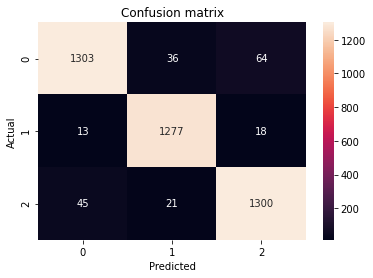

In [ ]:
from sklearn import metrics
import seaborn as sns

confuse = metrics.confusion_matrix(val_label, predict)
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
F1_score = metrics.f1_score(val_label, predict,average='weighted')
precision_score= metrics.precision_score(val_label, predict,average='weighted')
recall_score = metrics.recall_score(val_label, predict,average='weighted')

print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))

F1 score: 0.952
Precision score: 0.952
Recall score: 0.952
